In [147]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import scipy.stats as sstats
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from matplotlib.colors import Normalize
from lightning.pytorch import seed_everything

from dataset import camels2D_256_CV_CV_dataset
from model import LightVDM2,UNetThin2
from model import utils
from validation import power

device="cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def to_np(tensor):
    return tensor.detach().cpu().numpy()

In [148]:
seed_everything(7)

[rank: 0] Global seed set to 7


7

In [149]:
cropsize=256
gamma_min = -13.3
gamma_max = 5.0
embedding_dim= 48
norm_groups= 8
use_fourier_features= False
n_blocks= 4

vdm = LightVDM2(
        score_model=UNetThin2(
            gamma_min=gamma_min,
            gamma_max=gamma_max,

            embedding_dim=embedding_dim,
            norm_groups= norm_groups,
            use_fourier_features=use_fourier_features,
            n_blocks= n_blocks,
        ),
        image_shape=(1, cropsize,cropsize),
        gamma_min=gamma_min,
        gamma_max=gamma_max,
        noise_schedule = "learned_linear",
        learning_rate=1e-4
    )
vdm=vdm.to(device=device)
vdm=vdm.eval()

In [150]:
ckpt="/n/holylfs05/LABS/finkbeiner_lab/Everyone/cpark/CAMELS_diffusion_models/2D_LH_256/epoch=53-step=60000.ckpt"
state_dict=torch.load(ckpt)["state_dict"]
vdm.load_state_dict(state_dict)

<All keys matched successfully>

In [151]:
#input normalization
mean_input= 0.120691165 #mean 256^2 Mstar
std_input= 1.0848483 #std 256^2 Mstar
mean_target= 10.9838705 #mean 256^2 Mcdm
std_target= 0.50825393 #std 256^2 Mcdm

In [152]:
# load test data
mass_mstar = np.load(
                '/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps/Maps_Mstar_IllustrisTNG_1P_z=0.00.npy'
            )
mass_cdm = np.load(
                '/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps/Maps_Mcdm_IllustrisTNG_1P_z=0.00.npy'
            )
mass_mstar = np.log10(mass_mstar+1)
mass_mstar = torch.Tensor((mass_mstar - mean_input) / std_input).unsqueeze(1).unsqueeze(1)
mass_cdm = np.log10(mass_cdm)
mass_cdm = torch.Tensor((mass_cdm - mean_target) / std_target).unsqueeze(1).unsqueeze(1)

In [153]:
# selected indices for each parameter
selected = [[0, 5, 10], [11, 16, 21], [22, 27, 32], [33, 38, 43], [44, 49, 54], [55, 60, 65]]

indices = [idx * 15 for sublist in selected for idx in sublist]

In [154]:
params = pd.read_csv('/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps/params_1P_IllustrisTNG.txt', sep=' ', header=None)
labels = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{SN1}$', r'$A_{AGN1}$', r'$A_{SN2}$', r'$A_{AGN2}$']

In [155]:
pks_true = []
for field in mass_cdm:
    k, P, _ = power(field)
    pks_true.append(P)

990it [27:03,  1.64s/it]


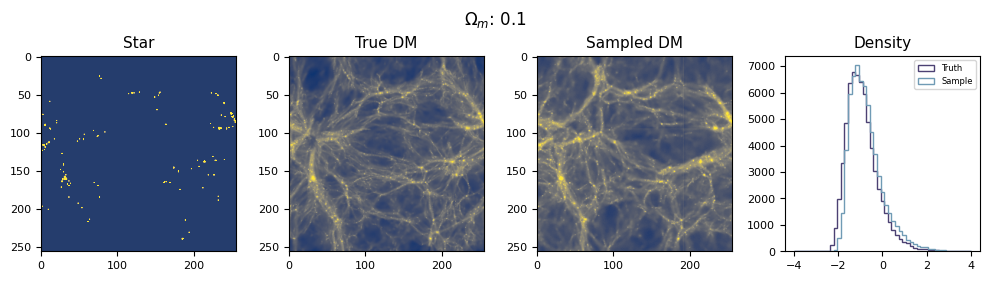

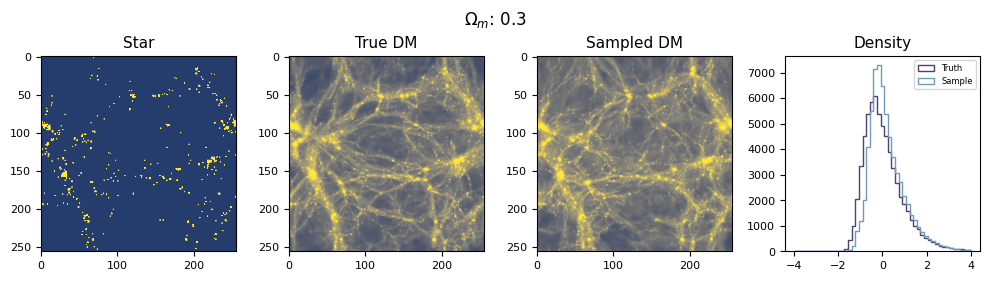

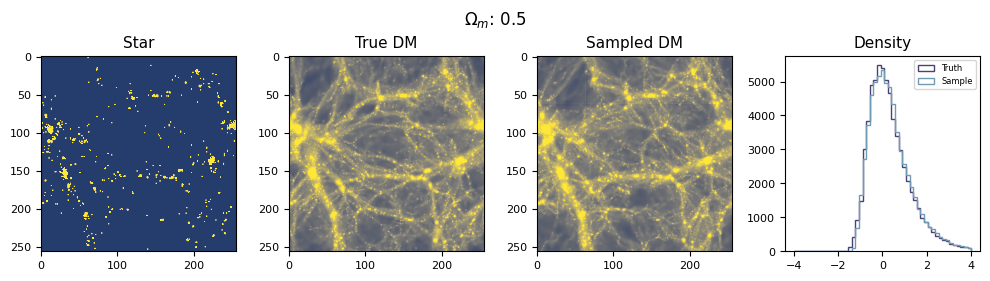

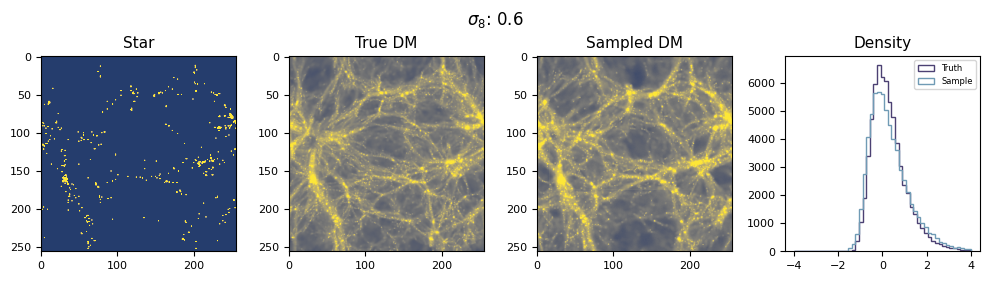

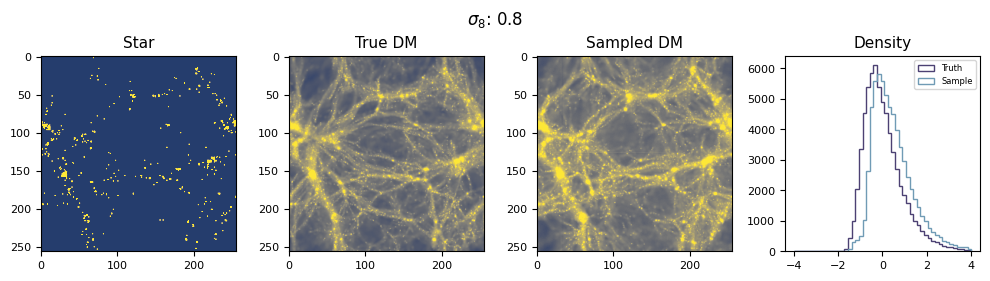

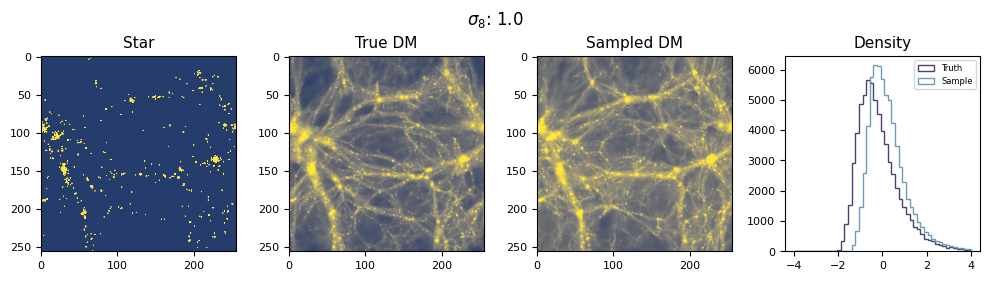

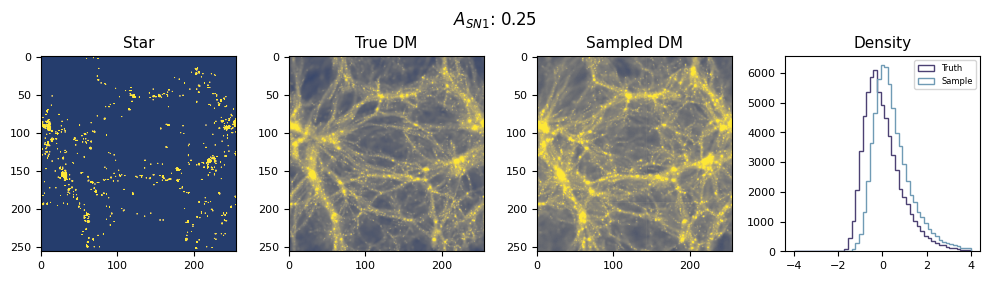

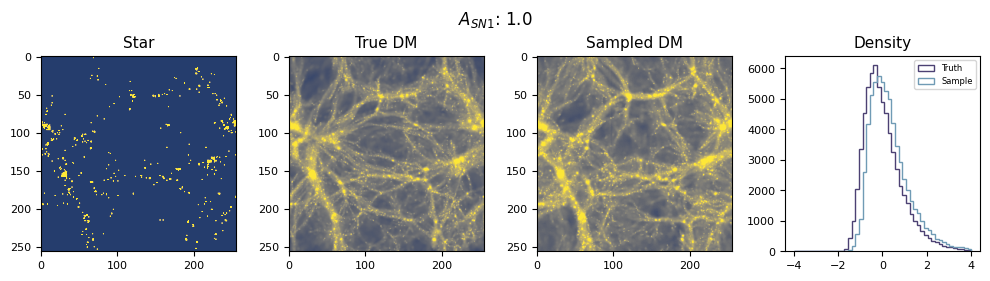

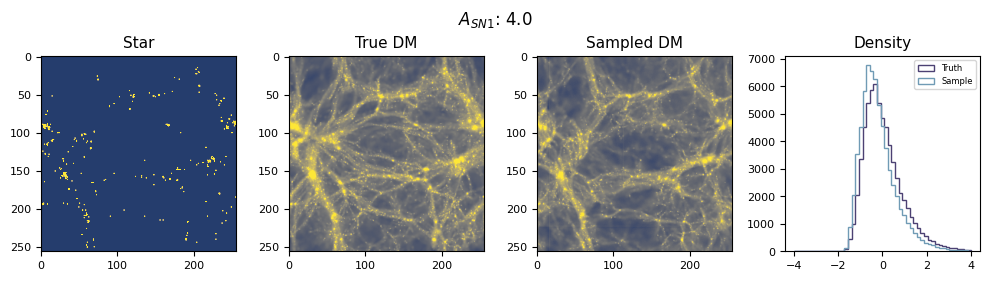

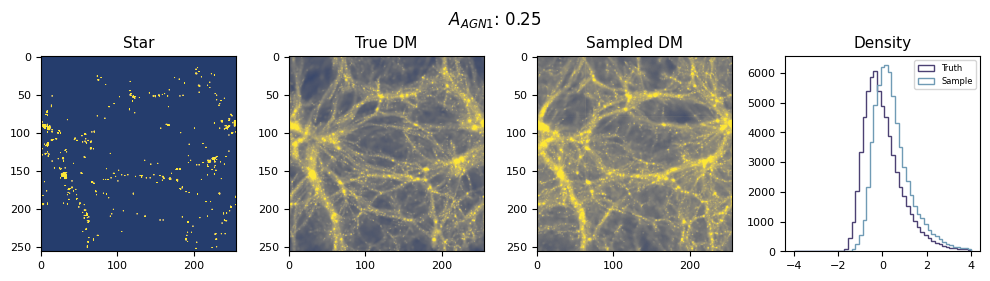

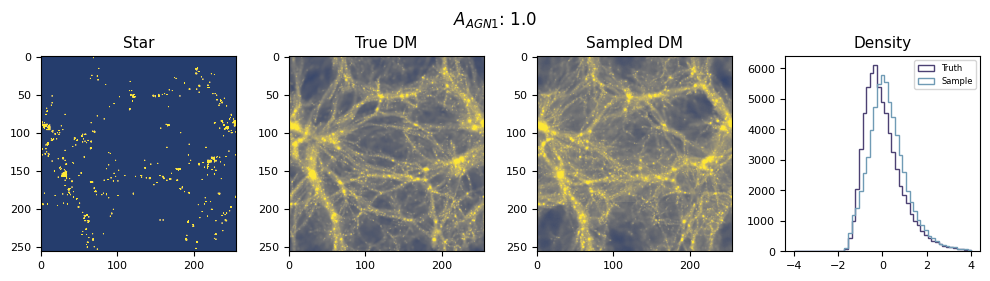

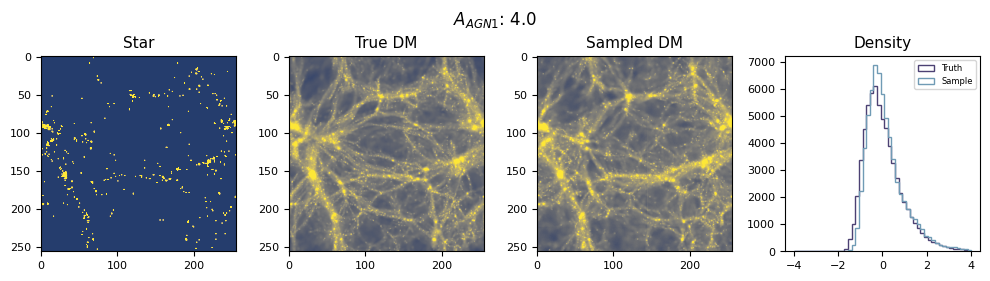

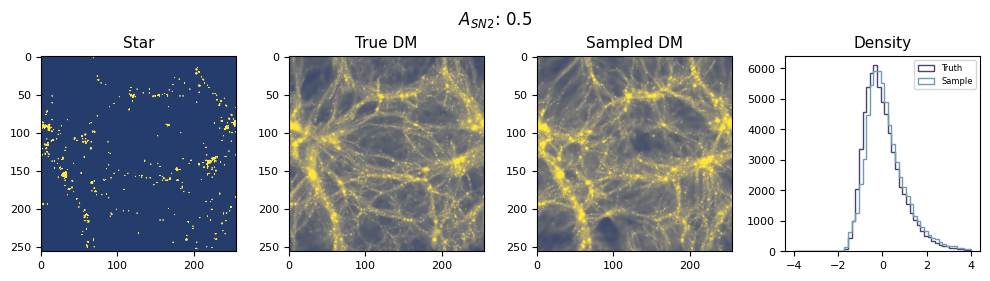

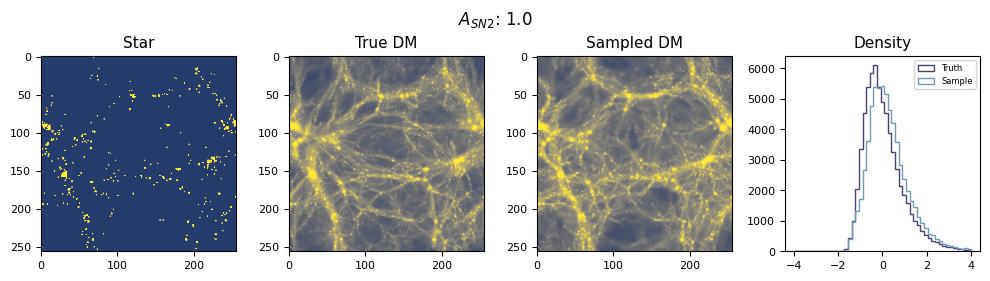

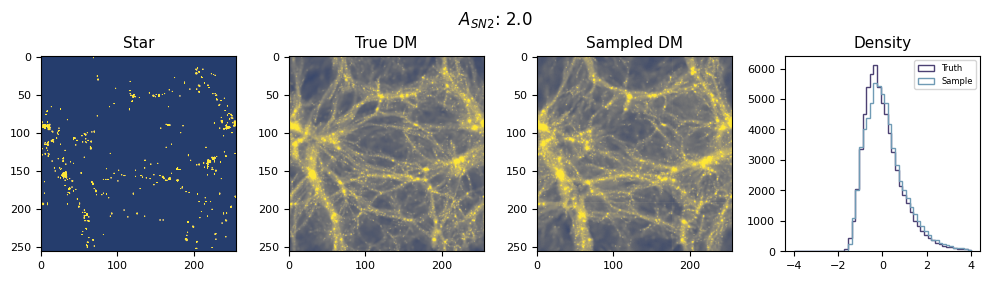

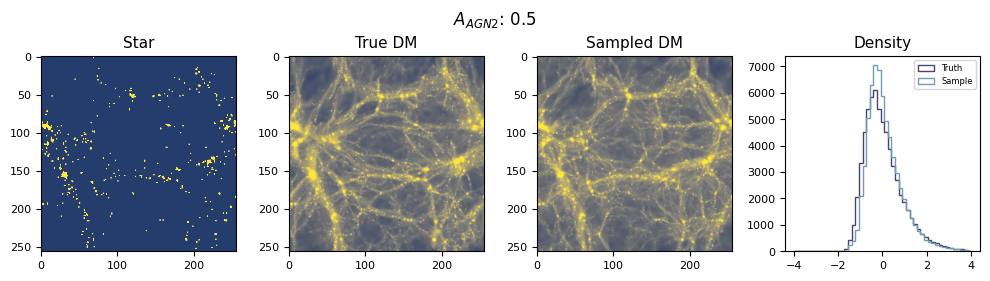

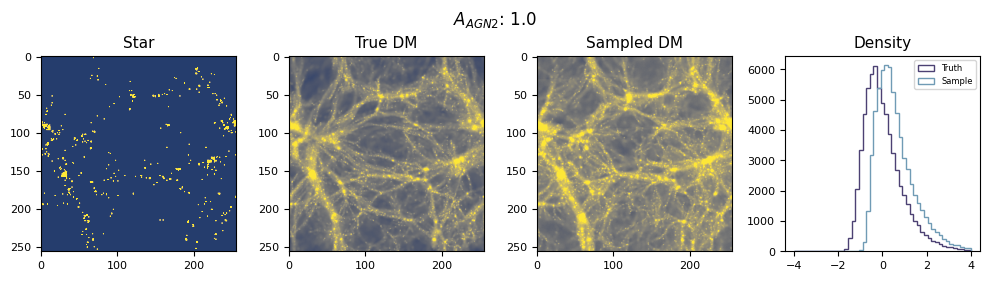

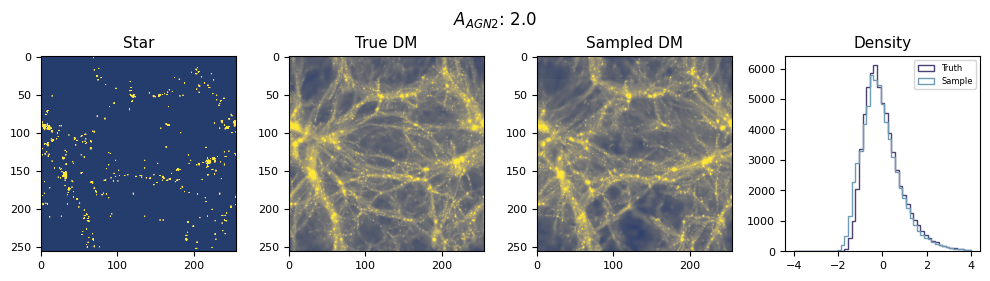

In [156]:
pks_pred = []
for i, (conditioning, x) in enumerate(tqdm.tqdm(zip(mass_mstar, mass_cdm))):
    conditioning, x = conditioning.to(device), x.to(device)
    sample = vdm.draw_samples(
                conditioning=conditioning,
                batch_size=len(x),
                n_sampling_steps=vdm.hparams.n_sampling_steps,
            )
    
    if i in indices:
        fig, axes = plt.subplots(1, 4,figsize=(10,3))
        axes[0].imshow(conditioning[0].squeeze().cpu(), cmap='cividis', vmin=-.5, vmax=2)
        axes[1].imshow(x[0].squeeze().cpu(), cmap='cividis', vmin=-3, vmax=3)
        axes[2].imshow(sample[0].squeeze().cpu(), cmap='cividis', vmin=-3, vmax=3)
        axes[0].set_title("Star")
        axes[1].set_title("True DM")
        axes[2].set_title("Sampled DM")
        axes[3].hist(x[0].cpu().numpy().flatten(), bins=np.linspace(-4, 4, 50), histtype='step', color='#4c4173', label="Truth")
        axes[3].hist(sample[0].cpu().numpy().flatten(), bins=np.linspace(-4, 4, 50), histtype='step', color='#709bb5', label="Sample")
        axes[3].set_title('Density')
        asp = np.diff(axes[3].get_xlim())[0] / np.diff(axes[3].get_ylim())[0]
        axes[3].set_aspect(asp)
        axes[3].legend()

        plt.rcParams.update({
            'axes.titlesize': 11,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'legend.loc': 'upper right',
            'legend.fontsize': 6
            })
        fig.tight_layout()
        fig.suptitle(f'{labels[i//15//11]}: {params[i//15//11][i//15]}')
        fig.savefig(f'./images/panels/panel_{i//15}.png', dpi=250)
        
    k, P, _ = power(sample)
    pks_pred.append(P)

In [157]:
colormap = sns.color_palette("flare", as_cmap=True)
norm = Normalize(vmin=0, vmax=2)

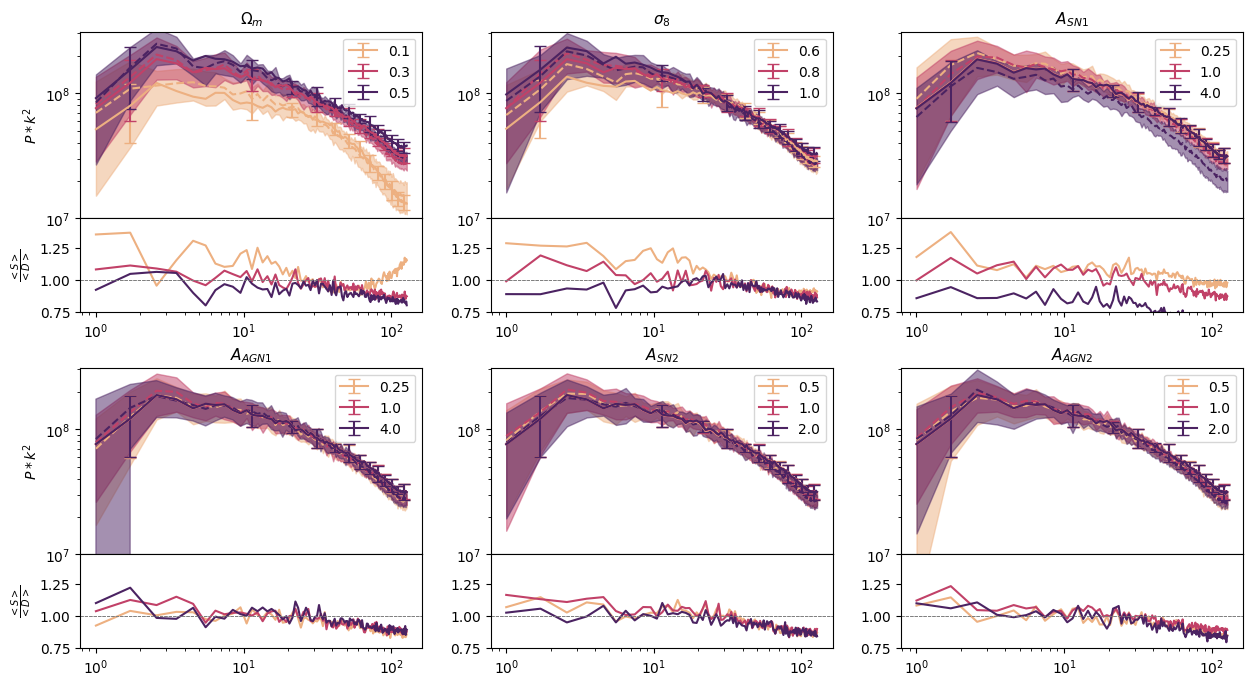

In [160]:
fig = plt.figure('constrained', figsize=(15, 8))
gs0 = gridspec.GridSpec(2, 3, figure=fig)

# index for outer loop
i = 0

for row in range(2):
    for col in range(3):
        plt.rcParams.update({
            'axes.titlesize': 11,
            'xtick.labelsize': 'medium',
            'ytick.labelsize': 'medium',
            'legend.loc': 'upper right',
            'legend.fontsize': 10
            })
        gs = gs0[row, col].subgridspec(2, 1, height_ratios=[2, 1], hspace=0)
        ax1 = fig.add_subplot(gs[0,0])
        ax1.tick_params(labelbottom=False)
        ax2 = fig.add_subplot(gs[1,0])
        ax1.set_ylim(1e7, 3.1e8)
        ax2.set_ylim(0.75, 1.48)
        if col==0:
            ax1.set_ylabel(r'$P*k^2$')
            ax2.set_ylabel(r'$\frac{<S>}{<D>}$')

        cm = 0
        for j in selected[i]:
            color = colormap(norm(cm))
            avg_pred = torch.mean(torch.stack(pks_pred[j*15:j*15+15]), axis=0)
            std_pred = torch.sqrt(torch.var(torch.stack(pks_pred[j*15:j*15+15]), axis=0))
            avg_true = torch.mean(torch.stack(pks_true[j*15:j*15+15]), axis=0)
            std_true = torch.sqrt(torch.var(torch.stack(pks_true[j*15:j*15+15]), axis=0))
            ax1.loglog(k.cpu(), avg_pred.cpu()*(k.cpu()**2), color=color, linestyle='dashed')
            ax1.errorbar(k.cpu(), avg_true.cpu()*(k.cpu()**2), yerr=std_true.cpu()*(k.cpu()**2), capsize=4, errorevery=(1, 10), color=color, label=params.iloc[j][i])
            ax1.fill_between(k.cpu(), (avg_pred.cpu() - std_pred.cpu())*(k.cpu()**2), (avg_pred.cpu() + std_pred.cpu())*(k.cpu()**2), alpha=0.5, color=color)
            ax1.legend(loc='upper right')
            ratio = avg_pred.cpu() / avg_true
            ax2.plot(k.cpu(), ratio, color=color)
            ax2.axhline(y=1, color='grey', lw=0.6, ls='dashed')
            cm += 1
        
        ax1.set_title(labels[i])
        ax2.set_xscale('log')
        
        i = i + 1
    
plt.show()

In [62]:
fig.savefig('./images/power_spectra_panels.png', dpi=250)